In [2]:
import aug_util as aug
import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
#import matplotlib, copy, skimage, os, tifffile
from skimage import io, morphology, draw
import gdal
from PIL import Image
import random
import json
from tqdm import tqdm
import io
import glob
import shutil
import os

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
# big_tiff_id = ['105001000B95E200_3002321', '105001000B95E200_3020303', '1040010032211E00_2112000', '105001000B9D7E00_3030320', '105001000B9D7E00_3030302', '105001000B9D7F00_3030303', '1040010032211E00_2110221', '105001000B95E200_3002231', '1040010032211E00_2110203', '1030010070C13600_3030230', '1030010070C13600_3030213', '1030010070C13600_3030211', '1040010032211E00_2110222', '1030010070C13600_3030233', '105001000B95E100_3020020', '105001000B95E200_3020330', '1030010070C13600_3030231', '105001000B95E200_3020321', '1040010032211E00_2112020', '105001000B95E200_3020301', '1040010032211E00_2112002', '105001000B95E100_2131131', '105001000B95E200_3002332', '105001000B95E100_3020021', '1040010032211E00_2110223', '1040010032211E00_2112001', '105001000B95E200_3020310', '105001000B95E200_3020132', '1040010032211E00_2110202', '105001000B95E200_3020123', '105001000B95E200_3020231', '1040010032211E00_2110022', '105001000B95E200_3020312', '105001000B95E200_3002233', '105001000B95E200_3020100', '1030010070C13600_3030232', '1030010070C13600_3030031', '105001000B9D7E00_3030031', '1030010070C13600_3030210', '105001000B95E100_3020203', '1040010032211E00_2110021', '1030010070C13600_3030212', '105001000B95E200_3002320', '105001000B95E100_2131133', '1040010032211E00_2110023', '105001000B95E200_3002323', '105001000B95E100_2131311', '105001000B95E200_3002322', '105001000B95E100_3020030', '105001000B95E200_3002330', '105001000B9D7E00_3030120', '105001000B9D7F00_3030120', '1040010032211E00_2110220', '105001000B9D8100_3030323', '1040010032211E00_2112003', '105001000B9D7F00_3030321', '1040010032211E00_2110200', '105001000B95E100_3020221', '10400100324DAE00_3030330', '1040010032211E00_2110201', '1040010032211E00_2112022', '105001000B9D7E00_3032100', '105001000B9D7E00_3030322', '105001000B95E200_3020011', '105001000B95E200_3020130', '105001000B95E100_3020212', '105001000B95E200_3020212', '105001000B95E200_3020121', '105001000B95E100_3020000', '105001000B95E200_3020013', '1040010032211E00_2110020', '105001000B95E100_3020202', '105001000B95E200_3020320', '105001000B95E200_3020302', '105001000B95E200_3020213', '105001000B95E100_3020213', '105001000B9D7E00_3030211', '105001000B95E100_3020230', '105001000B95E100_3020200', '105001000B9D8100_3032101', '105001000B9D7E00_3030300', '105001000B95E200_3020110', '105001000B95E200_3020101', '10400100324DAE00_3030312', '1030010070C13600_3030012', '105001000B95E100_3020011', '105001000B95E200_3020300', '10400100324DAE00_3032331', '10400100324DAE00_3032313', '105001000B95E200_3020030', '105001000B95E200_3020103', '105001000B95E200_3020010', '105001000B95E100_3020010', '105001000B9D8100_3030332', '105001000B9D7F00_3030123', '1040010032211E00_2112023', '105001000B9D7F00_3030121', '105001000B9D7F00_3030130', '105001000B9D7F00_3030132', '105001000B95E200_3020122', '105001000B95E200_3020033', '105001000B95E200_3020120', '105001000B95E200_3020230', '105001000B95E200_3020031', '105001000B9D7F00_3030301', '1030010070C13600_3030033', '105001000B95E100_2131113', '105001000B95E100_3020032', '105001000B95E100_3020220', '105001000B95E100_3020023', '10400100324DAE00_3210111', '10400100324DAE00_3032312', '10400100324DAE00_3032333', '105001000B95E100_3020210', '105001000B9D8100_3032110', '10400100324DAE00_3032310']
# big_tiff_set = set(big_tiff_id)


In [4]:
# modified to buffer the bounding boxes by 15 pixels
def get_labels(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
    x_off = 15
    y_off = 15
    add_np = np.array([-x_off, -y_off, x_off, y_off])
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try: 
                b_id = data['features'][i]['properties']['IMAGE_ID']
#                 if b_id == '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif':
#                     print('found chip!')
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['TYPE_ID']
            except:
#                 print('i:', i)
#                 print(data['features'][i]['properties']['bb'])
                  pass
            if val.shape[0] != 4:
                print("Issues at %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'
    # debug
    # added offsets to each coordinates
    # need to check the validity of bbox maybe
    coords = np.add(coords, add_np)
    
    return coords, chips, classes

In [5]:
fname = '../just_buildings_w_uid_second_round.geojson'
coords, chips, classes = get_labels(fname)

100%|██████████| 10770/10770 [00:00<00:00, 82742.89it/s]


In [6]:
#chip_name = '20170902_105001000B9D7E00_3030300_jpeg_compressed_02_01.tif'

In [7]:
#test_classes = coords[chips ==chip_name]
#len(test_classes)

In [8]:
chip_list = chips.tolist()
print(len(set(chip_list)))

854


In [8]:
temp_list = set()
for chip_n in set(chip_list):
    chip_big_tiff_id_list = chip_n.split('_')[1:3]
    chip_big_tiff_id = '_'.join(chip_big_tiff_id_list)
    temp_list.add(chip_big_tiff_id)
    

print(len(temp_list))

113


In [9]:
# chip_path = '/home/ubuntu/anyan/harvey_data/converted_image_tiles_aws/'
# fnames = glob.glob(chip_path + "*.tif")
# temp_list2 = set()
# for f in fnames:
        
#         chip_name = f.split('/')[-1]
#         chip_big_tiff_id_list = chip_name.split('_')[1:3]
#         chip_big_tiff_id = '_'.join(chip_big_tiff_id_list)
#         temp_list2.add(chip_big_tiff_id)
# print(len(temp_list2))


In [10]:
# cat_id = set()
# with open(fname) as f:
#     data = json.load(f)
#     for i in range(len(data['features'])):
#         cat_id.add(data['features'][i]['properties']['CAT_ID'])
# print(cat_id)
    

In [11]:
chips.shape

(13674,)

In [12]:
# chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'

# inx = np.where(chips == chip_name)[0]
# coords[inx]

/home/ubuntu/anyan/harvey_data/converted_image_tiles_aws/20170901_1030010070C13600_3030230_jpeg_compressed_01_07.tif
(2048, 2048, 3)


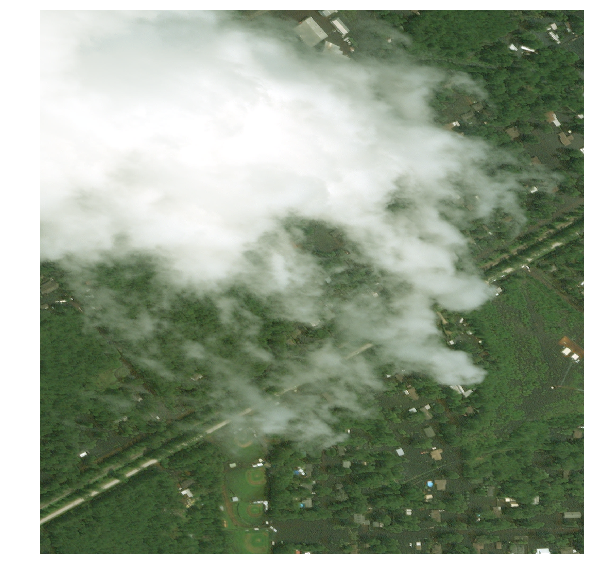

In [64]:

#Load an image
path = '/home/ubuntu/anyan/harvey_data/converted_image_tiles_aws/'

# fnames = glob.glob(path + "*.tif")
# for f in fnames:
#     chip_name = f.split('/')[-1]
#     print(chip_name)
#chip_name = '20170902_105001000B9D7E00_3030300_jpeg_compressed_02_01.tif'



#chip_name = '20170829_1040010032211E00_2112023_jpeg_compressed_10_10.tif' # with blackout
chip_name = '20170901_1030010070C13600_3030230_jpeg_compressed_01_07.tif'  # with clouds
#chip_name = '20170901_1030010070C13600_3030230_jpeg_compressed_02_07.tif'  # with clouds
#chip_name = '20170901_1030010070C13600_3030230_jpeg_compressed_01_10.tif'  # with clouds
#chip_name  = '20170901_1030010070C13600_3030230_jpeg_compressed_02_09.tif' # with black
#chip_name = '20170829_1040010032211E00_2112000_jpeg_compressed_05_09.tif'  # with clouds
#chip_name = '20170829_1040010032211E00_2112022_jpeg_compressed_10_04.tif'  # with clouds
#chip_name = '20170829_1040010032211E00_2112002_jpeg_compressed_01_04.tif'  # clouds
#chip_name = '20170829_1040010032211E00_2112002_jpeg_compressed_02_05.tif'
#chip_name = '20170829_1040010032211E00_2110203_jpeg_compressed_01_04.tif'  # clouds
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'
# chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_04_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_02.tif'
chip_fullname = path + chip_name
print(chip_fullname)
arr = wv.get_image(chip_fullname)

print(arr.shape)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(arr)

In [65]:
# take absolut path of chip files
# converted to png files

def draw_bbox_on_tiff(chip_path, coords, chips, classes, save_path):
    #Load an image
    #path = '/home/ubuntu/anyan/harvey_data/converted_sample_tiff/'
    
    
    # big tiff name: chip name
    # init to {big_tiff_name : []}
    #big_tiff_dict = dict((k, []) for k in big_tiff_set)

    fnames = glob.glob(chip_path + "*.tif")
    i = 0
    for f in fnames:
        
        chip_name = f.split('/')[-1]
        chip_big_tiff_id_list = chip_name.split('_')[1:3]
        chip_big_tiff_id = '_'.join(chip_big_tiff_id_list)
        print(chip_big_tiff_id)
        #if chip_big_tiff_id not in set(big_tiff_dict.keys()):
         #   big_tiff_dict[chip_big_tiff_id] = list()
          #  big_tiff_dict[chip_big_tiff_id].append(chip_name)
        #else:
            
#         if len(big_tiff_dict[chip_big_tiff_id]) < 5:


           #big_tiff_dict[chip_big_tiff_id].append(chip_name)
        arr = wv.get_image(f)
#             print(arr.shape)
    #         plt.figure(figsize=(10,10))
    #         plt.axis('off')
    #         plt.imshow(arr)
        coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
        if coords_chip.shape[0] == 0:
            print('no bounding boxes for this image')
            continue
        classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
        labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
        print(chip_name)
#             plt.figure(figsize=(15,15))
#             plt.axis('off')
#             plt.imshow(labelled)
        subdir_name = save_path + chip_big_tiff_id
        if os.path.isdir(subdir_name):
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
        else:
            os.mkdir(subdir_name)
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
           


In [66]:
# path = '/home/ubuntu/anyan/harvey_data/converted_image_tiles_aws/'
# save_path =  '/home/ubuntu/anyan/harvey_data/bbox_debug_png/'
# draw_bbox_on_tiff(path, coords, chips, classes, save_path)

In [67]:
# coords = coords[chips==chip_name]
# classes = classes[chips==chip_name].astype(np.int64)

In [68]:
print(classes)

[1. 1. 1. ... 2. 2. 2.]


[[1378.  -15. 1449.   23.]
 [1040.  -15. 1195.   38.]
 [1911.   29. 1972.   92.]
 [1086.    8. 1185.  108.]
 [ 952.    5. 1103.  158.]
 [1757.  112. 1822.  172.]
 [1038.   98. 1179.  224.]
 [1835.  645. 1902.  703.]
 [1895.  649. 1970.  715.]
 [1627.  678. 1680.  738.]
 [1603.  714. 1656.  765.]
 [1398.  756. 1469.  831.]
 [1579.  827. 1668.  911.]
 [1238.  865. 1301.  926.]
 [1162.  886. 1235.  958.]
 [ -11. 1087.   62. 1146.]
 [1136. 1092. 1209. 1151.]
 [1066. 1109. 1143. 1190.]
 [1018. 1137. 1089. 1207.]
 [ 958. 1196. 1005. 1247.]
 [1208. 1325. 1263. 1375.]
 [1344. 1345. 1407. 1411.]
 [1503. 1343. 1582. 1416.]
 [1372. 1405. 1459. 1487.]
 [ 904. 1452.  977. 1524.]
 [ 131. 1634.  210. 1700.]
 [1178. 1874. 1273. 1953.]
 [1051. 2024. 1134. 2107.]
 [1052. 1848. 1136. 1931.]
 [1052. 1757. 1136. 1840.]
 [1045. 1675. 1128. 1759.]
 [1010. 1471. 1094. 1555.]
 [ 961. 1408. 1045. 1492.]
 [1047. 1587. 1131. 1671.]
 [ 176. 1138.  260. 1221.]
 [ 243. 1212.  326. 1296.]
 [ 465. 1473.  549. 1556.]
 

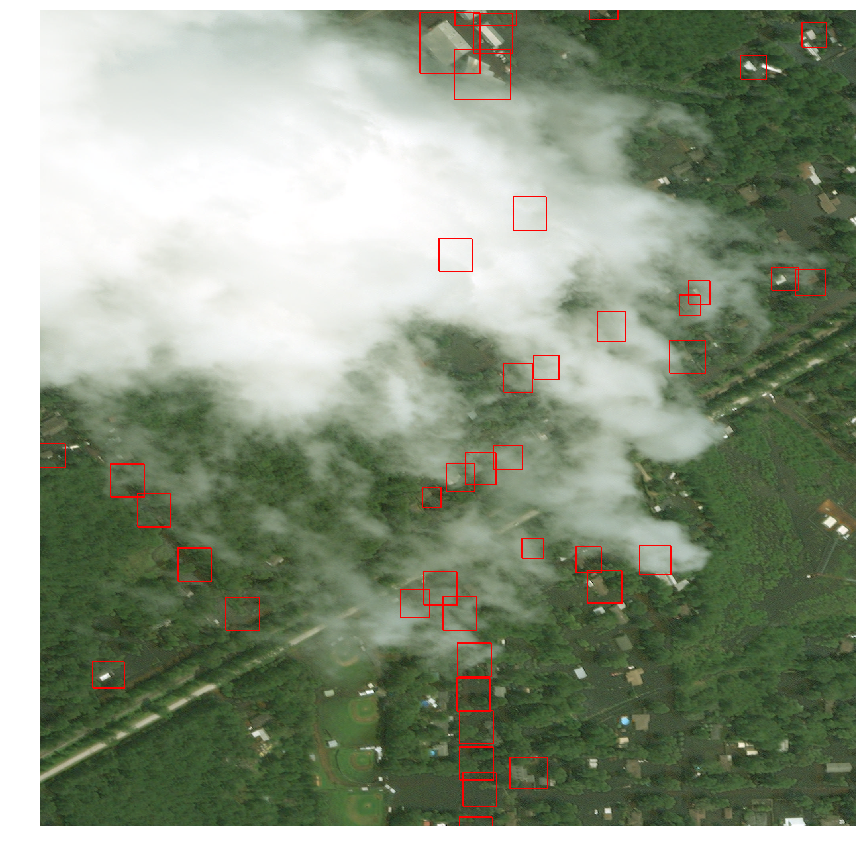

In [69]:
coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
print(coords_chip)
classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
print(classes_chip)
labelled = aug.draw_bboxes(arr,coords_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

In [70]:
#We can chip the image into 500x500 chips
c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords_chip, classes=classes_chip, shape=(512,512))
print("Num Chips: %d" % c_img.shape[0])

Num Chips: 16


In [71]:
len(c_box[2])

5

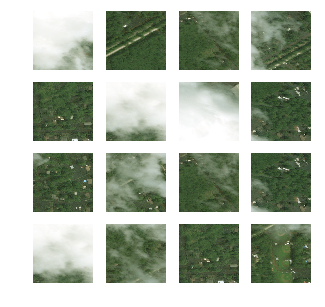

In [72]:
#We can plot some of the chips
fig,ax = plt.subplots(4)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(16):
    plt.subplot(4,4,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

In [73]:
# detect black blocks in an image
# take an img in array format
# determine whether the area of the black portion is larger than a threshold: 0.1
# return True if the img contain large portions of black 

def detect_blackblock(img):
    # check the # of pixels that with RGB values are all equal to 0
    w,h,c = img.shape
    black_pixel_count=0
    threshold = 0.9 * w * h * 3
    non_black_count = np.count_nonzero(img)
    if non_black_count > threshold:
        return False
    else:
        return True
    
#     for i in range(w):
#         for j in range(h):
# #             print()
#             #if img[i,j,0]== 0 and img[i,j,1]== 0 and img[i,j,2]== 0:
#             if np.all(img[i,j,:] ==0):
#                 black_pixel_count+=1
#                 if black_pixel_count > threshold:
#                     return True


    

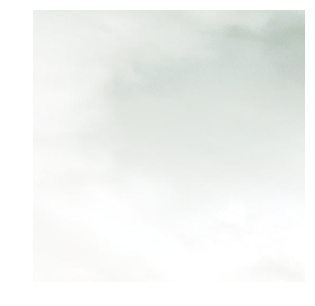

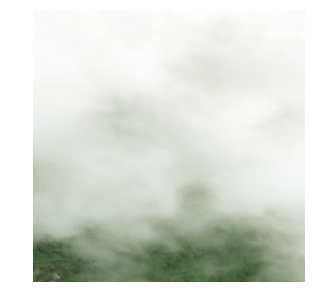

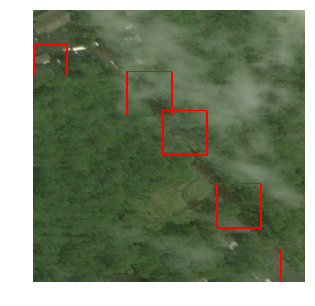

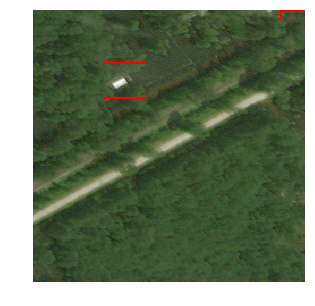

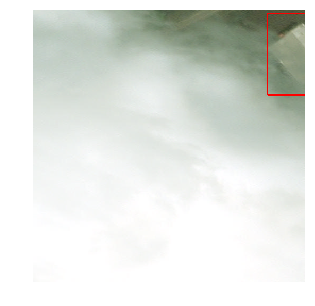

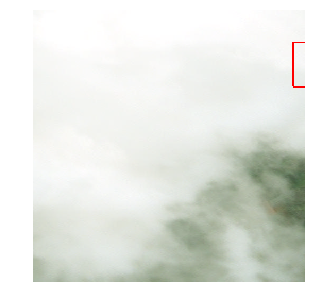

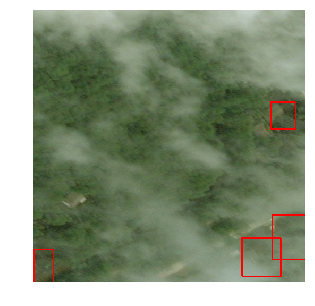

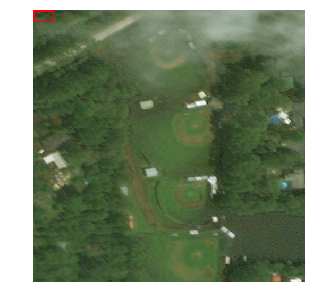

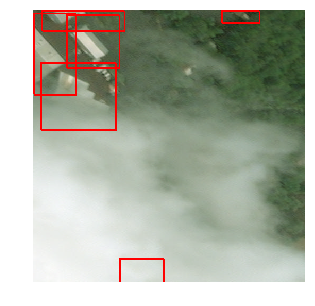

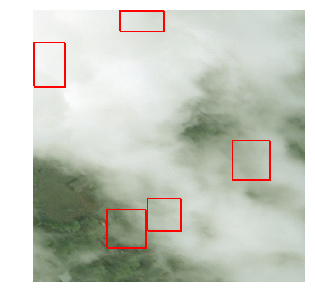

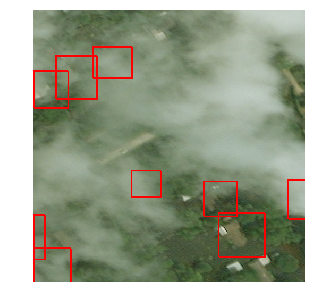

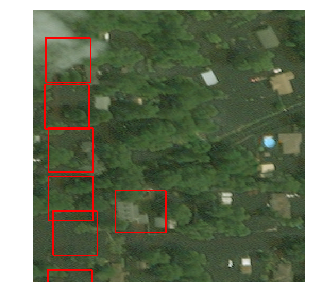

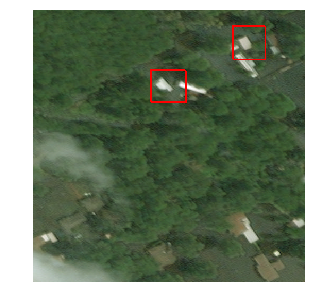

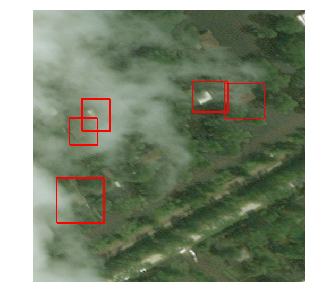

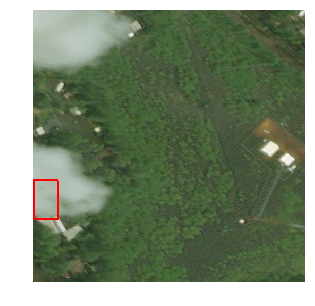

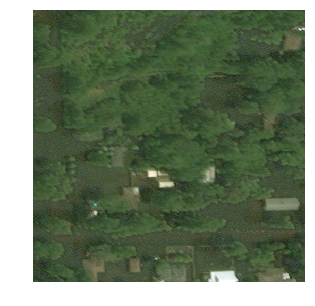

In [74]:
#We can visualize the chips with their labels
for ind in range(0, c_img.shape[0]):
    #ind = np.random.choice(range(c_img.shape[0]))
    if detect_blackblock(c_img[ind]): # contain black, ignore
        print('black!')
        continue
    labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(labelled)
    #print(c_img[ind])

In [75]:
detect_blackblock(arr)

False

In [76]:
print(coords_chip.shape)

(41, 4)


In [80]:

def detect_clouds(img,  boxes, classes):
    mean_threshold_min = 160
    w, h, _ = img.shape
    print('w,h', w, h)
    var_threshold = 18
    rows_to_delete = list()
    for i in range(boxes.shape[0]):
        xmin, ymin, xmax, ymax = boxes[i]
#         ymin = 0
        if xmin < 0:
            xmin = 0
        if ymin<0:
            y_min = 0
        if xmax > h:
            print('xmax > h')
            xmax = h
        if ymax > w:
            print('ymax > w')
            ymax= h
        print(xmin, ymin, xmax, ymax)
        # clip bbox areas
        #cropped_img = img.crop((xmin, ymin, xmax, ymax))
        cropped_img = img[int(ymin):int(ymax), int(xmin):int(xmax)]  # note the order of w/h
#         print(cropped_img)
#         print(cropped_img.shape)
        array_img =  np.array(cropped_img)
        mean_img = np.mean(array_img)
        
        print('mean_img', mean_img, i)
        var_img = np.std(array_img)
        print('var_img',var_img, i)
        #if var_img < var_threshold and (cropped_img> 150).all() and (cropped_img< 255).all():
        if var_img < var_threshold and mean_img > mean_threshold_min:
            print('bounding box i has cloud', i)
            # need to delete this bbox
            rows_to_delete.append(i)
    print('rows_to_delete',rows_to_delete)
            
    if len(rows_to_delete) == 0:
        return img,  boxes, classes
    else:
        # return boxes and classes with clouds removed
        new_coords = np.delete(boxes, rows_to_delete, axis=0)
        new_classes = np.delete(classes, rows_to_delete, axis=0)
        return img, new_coords, new_classes
        
        
    
        
        
        
    

In [81]:
img, new_coords, new_classes = detect_clouds(arr, coords_chip, classes_chip)

# print(detect_clouds(arr, coords_chip))

w,h 2048 2048
1378.0 -15.0 1449.0 23.0
mean_img nan 0
var_img nan 0
1040.0 -15.0 1195.0 38.0
mean_img nan 1
var_img nan 1
1911.0 29.0 1972.0 92.0
mean_img 88.71211726949431 2
var_img 40.43881892333688 2
1086.0 8.0 1185.0 108.0
mean_img 106.17468013468013 3
var_img 40.45904099994289 3
952.0 5.0 1103.0 158.0
mean_img 120.85912363473719 4
var_img 32.8577404620466 4
1757.0 112.0 1822.0 172.0
mean_img 89.43512820512821 5
var_img 48.05168314626129 5
1038.0 98.0 1179.0 224.0
mean_img 134.4948590941499 6
var_img 33.14581418180313 6
1835.0 645.0 1902.0 703.0
mean_img 91.25278778521186 7
var_img 33.71441374980133 7
1895.0 649.0 1970.0 715.0
mean_img 84.7512457912458 8
var_img 21.95088349763608 8
1627.0 678.0 1680.0 738.0
mean_img 142.59622641509435 9
var_img 17.32341474849335 9
1603.0 714.0 1656.0 765.0
mean_img 121.78579356270811 10
var_img 17.05771695334489 10
1398.0 756.0 1469.0 831.0
mean_img 176.31311424100156 11
var_img 12.060073426504363 11
bounding box i has cloud 11
1579.0 827.0 1668.0 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


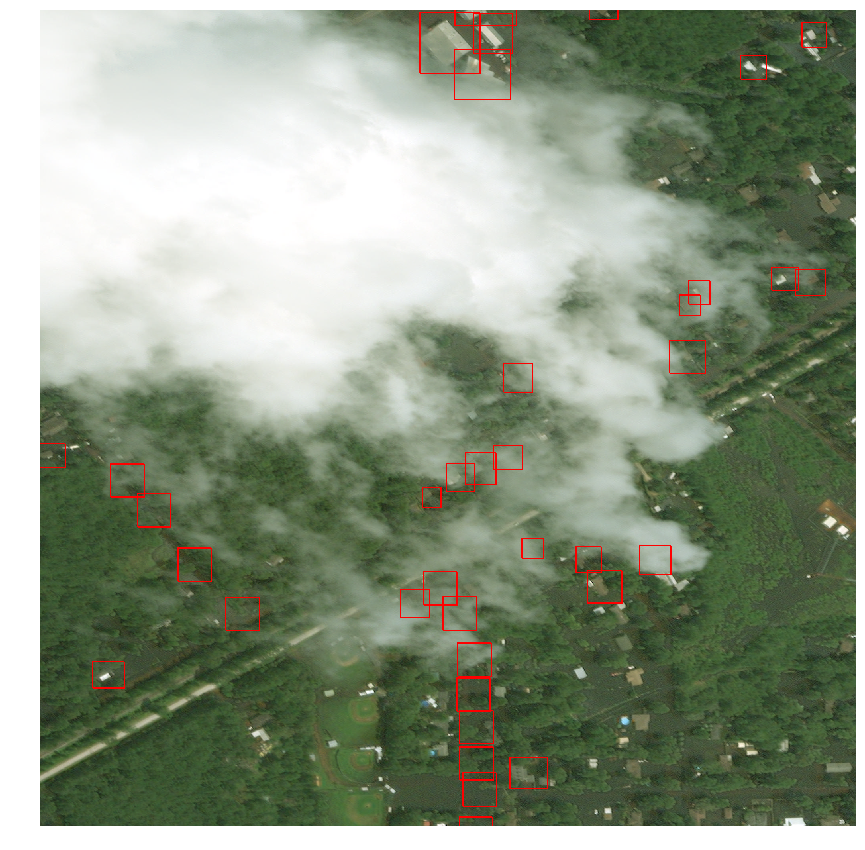

In [82]:


# coords_chip = coords[chips==chip_name]

#             #print(coords_chip.shape)
# new_coords = list()
# new_coords=coords_chip[ind]
# print(new_coords)



# classes_chip = classes[chips==chip_name].astype(np.int64)
#     #         #We can chip the image into 500x500 chips
#     #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
#     #         print("Num Chips: %d" % c_img.shape[0])
# print(classes_chip)
labelled = aug.draw_bboxes(arr,new_coords)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

In [193]:




# labelled = aug.draw_bboxes(arr,coords[classes ==1])
# plt.figure(figsize=(15,15))
# plt.axis('off')
# plt.imshow(labelled)

In [95]:
# labelled.save("test.png")